**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_)    
- [Load data](#toc2_)    
- [Get data for BERT](#toc3_)    
- [Run BERT](#toc4_)    
  - [Import model](#toc4_1_)    
  - [Tokenize & Encode the sequences](#toc4_2_)    
  - [Data Loader](#toc4_3_)    
  - [Model Architecture](#toc4_4_)    
  - [Fine Tune](#toc4_5_)    
- [Model Performance](#toc5_)    
- [Save Model](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Imports](#toc0_)

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.optim import AdamW

In [3]:
INPUT_FILE = fr'/kaggle/input/asrs-aeroguard/01_df_train_val_test.pkl'
OUTPUT_WEIGHTS_PATH = '/kaggle/working/saved_weights.pt'

device = torch.device('cuda')
# device = torch.device('cpu')
device

device(type='cuda')

# <a id='toc2_'></a>[Load data](#toc0_)

In [4]:
df_train_val_test = pd.read_pickle(INPUT_FILE)

df_train = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Train"')
print(f'{df_train.shape=}')
df_val = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Validation"')
print(f'{df_val.shape=}')
df_test = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Test"')
print(f'{df_test.shape=}')

df_train_val_test

df_train.shape=(38655, 114)
df_val.shape=(4295, 114)
df_test.shape=(4773, 114)


,ACN_NUM_ACN,TIME_DATE,TIME_1_LOCAL_TIME_OF_DAY,PLACE_LOCALE_REFERENCE,PLACE_1_STATE_REFERENCE,PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL,PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES,PLACE_4_ALTITUDE_AGL_SINGLE_VALUE,PLACE_5_ALTITUDE_MSL_SINGLE_VALUE,ENVIRONMENT_FLIGHT_CONDITIONS,...,ASSESSMENTS_CONTRIBUTING_FACTORS_SITUATIONS,ASSESSMENTS_1_PRIMARY_PROBLEM,REPORT_1_NARRATIVE,REPORT_1_1_CALLBACK,REPORT_2_NARRATIVE,REPORT_2_1_CALLBACK,REPORT_1_2_SYNOPSIS,TRAIN_VAL_TEST_SPLIT,EVENT_RISK,EVENT_RISK_STR
0,1574675,201808,0601-1200,SNA.Airport,CA,NaN,NaN,NaN,5000.0,NA,...,Human Factors,Human Factors,SNA RNP-Z to Runway 20R. The FMC was properly ...,NA,We were cleared for the RNP RNAV Z 20R Approac...,NA,B737-700 flight crew reported failing to make ...,Train,2,Medium risk
1,1224894,201412,0601-1200,MSY.Airport,LA,NaN,NaN,1000.0,NaN,VMC,...,Human Factors,Human Factors,On base to final turn to runway 1 in MSY at ap...,NA,NA,NA,Captain reports sighting of a drone at 1;000 f...,Train,0,Low risk
2,1134202,201312,1201-1800,ZZZ.ARTCC,US,NaN,NaN,NaN,2600.0,IMC,...,Human Factors; Aircraft; Procedure; Weather,Aircraft,I climbed to my filed altitude of 5;000 FT; an...,NA,NA,NA,SR22 pilot became disoriented on approach in I...,Train,3,Moderately high risk
3,1222074,201411,1201-1800,CWA.Airport,WI,NaN,20.0,NaN,4000.0,NA,...,Aircraft,Aircraft,I had my pitot heat checked prior to winter an...,NA,NA,NA,BE58 pilot experiences pitot heat failure desc...,Train,2,Medium risk
4,1733019,202003,1801-2400,ZDV.ARTCC,CO,NaN,NaN,NaN,32000.0,NA,...,Airspace Structure; Weather,Weather,At 32000 ft. just north of PUB the aircraft ex...,NA,NA,NA,B737 First Officer reported unexpected moderat...,Train,3,Moderately high risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,1341108,201603,0601-1200,ZZZ.Airport,US,NaN,NaN,NaN,NaN,IMC,...,Company Policy; Human Factors,Human Factors,We did an originator out of ZZZ and had a main...,NA,[Report narrative contained no additional info...,NA,CRJ-900 flight crew reported being dispatched ...,Test,3,Moderately high risk
47719,1087474,201305,1201-1800,PHX.Airport,AZ,NaN,NaN,NaN,8000.0,VMC,...,Aircraft; Human Factors; Procedure,Ambiguous,PHX takeoff Runway 25R flaps 5. CLEARANCE: MAX...,NA,There was an Airbus that departed before us an...,NA,CE750 flight crew departing PHX Runway 25R on ...,Test,3,Moderately high risk
47720,1756601,202008,NA,NA,NA,NaN,NaN,0.0,NaN,NA,...,Environment - Non Weather Related; Company Pol...,Company Policy,I was scheduled to complete the one day traini...,NA,NA,NA,Air carrier First Officer reported that re-qua...,Test,0,Low risk
47721,1102938,201307,0601-1200,MEM.Airport,TN,NaN,NaN,NaN,NaN,VMC,...,Airspace Structure; Chart Or Publication; Proc...,Human Factors,We departed Runway 36C in MEM via the GOETZ TW...,NA,NA,NA,On initial climb out via the GOETZ RNAV SID fr...,Test,2,Medium risk


# <a id='toc3_'></a>[Get data for BERT](#toc0_)

In [5]:
train_text = df_train['REPORT_1_NARRATIVE']
train_labels = df_train['EVENT_RISK']

val_text = df_val['REPORT_1_NARRATIVE']
val_labels = df_val['EVENT_RISK']

test_text = df_test['REPORT_1_NARRATIVE']
test_labels = df_test['EVENT_RISK']

print(f'{train_text.shape=}')
print(f'{train_labels.shape=}')
print(f'{val_text.shape=}')
print(f'{val_labels.shape=}')
print(f'{test_text.shape=}')
print(f'{test_labels.shape=}')

train_text.shape=(38655,)
train_labels.shape=(38655,)
val_text.shape=(4295,)
val_labels.shape=(4295,)
test_text.shape=(4773,)
test_labels.shape=(4773,)


# <a id='toc4_'></a>[Run BERT](#toc0_)

## <a id='toc4_1_'></a>[Import model](#toc0_)

In [6]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<Axes: >

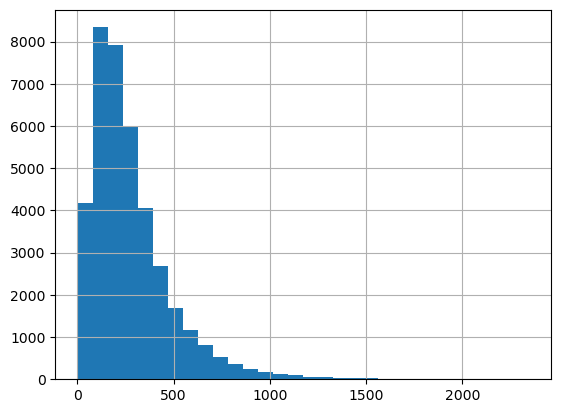

In [7]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

## <a id='toc4_2_'></a>[Tokenize & Encode the sequences](#toc0_)

In [8]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    padding=True,
    truncation=True
)

In [9]:
print(len(tokens_train['input_ids'][0]))
print(len(tokens_train['input_ids'][1]))
print(len(tokens_train['input_ids'][2]))
print(len(tokens_train['input_ids'][4]))
print(len(tokens_train['input_ids'][6]))

512
512
512
512
512


In [10]:
# convert to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## <a id='toc4_3_'></a>[Data Loader](#toc0_)

In [11]:
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## <a id='toc4_4_'></a>[Model Architecture](#toc0_)

In [12]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [13]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__() 
        self.bert = bert 
        self.dropout = nn.Dropout(0.1)      
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,5)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [14]:
model = BERT_Arch(bert).to(device)

optimizer = AdamW(model.parameters(),lr = 1e-5) 

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print(f'{class_weights=}')

class_weights=array([0.88770238, 1.65298268, 0.57706949, 1.30349014, 1.30129608])


In [15]:
weights = torch.tensor(class_weights,dtype=torch.float).to(device)
cross_entropy = nn.NLLLoss(weight=weights) 

## <a id='toc4_5_'></a>[Fine Tune](#toc0_)

In [16]:
epochs = 10

def train():
    model.train()
    total_loss, total_accuracy = 0, 0
  
    total_preds = []
    total_labels = []
  
    for step,batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        
        model.zero_grad()        
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        
        total_loss = total_loss + loss.item()
        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        total_preds.append(preds)
        total_labels.append(labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions and labels are in the form of (num_batches, batch_size, num_classes).
    # reshape the predictions in form of (num_samples=num_batches*batch_size, num_classes)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    f1 = f1_score(total_labels, total_pred, average='weighted')
    return avg_loss, f1

In [17]:
def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0
    
    total_preds = []
    total_labels = []

    for step,batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels)
            
    avg_loss = total_loss / len(val_dataloader) 
    total_preds  = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    f1 = f1_score(total_labels, total_pred, average='weighted')
    return avg_loss, f1

In [18]:
# test saving model weights
torch.save(model.state_dict(), OUTPUT_WEIGHTS_PATH)
print('Saving weights worked!')

Saving weights worked!


In [19]:
# test saving model
MODEL_PATH = '/kaggle/working/bert_model.pt'
torch.save(model, MODEL_PATH)
print('Saving model worked!')

Saving model worked!


In [20]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]
train_f1s=[]
valid_f1s=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    train_loss, train_f1 = train()
    valid_loss, train_f1 = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_f1s.append(train_f1)
    valid_f1s.append(valid_f1)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
#     print(f'Training F1: {train_f1:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
#     print(f'Validation F1: {valid_f1:.3f}')


 Epoch 1 / 10
  Batch    50  of    302.
  Batch   100  of    302.
  Batch   150  of    302.
  Batch   200  of    302.
  Batch   250  of    302.
  Batch   300  of    302.

Evaluating...

Training Loss: 1.604
Validation Loss: 1.594

 Epoch 2 / 10
  Batch    50  of    302.
  Batch   100  of    302.
  Batch   150  of    302.
  Batch   200  of    302.
  Batch   250  of    302.
  Batch   300  of    302.

Evaluating...

Training Loss: 1.591
Validation Loss: 1.587

 Epoch 3 / 10
  Batch    50  of    302.
  Batch   100  of    302.
  Batch   150  of    302.
  Batch   200  of    302.
  Batch   250  of    302.
  Batch   300  of    302.

Evaluating...

Training Loss: 1.583
Validation Loss: 1.576

 Epoch 4 / 10
  Batch    50  of    302.
  Batch   100  of    302.
  Batch   150  of    302.
  Batch   200  of    302.
  Batch   250  of    302.
  Batch   300  of    302.

Evaluating...

Training Loss: 1.576
Validation Loss: 1.567

 Epoch 5 / 10
  Batch    50  of    302.
  Batch   100  of    302.
  Batch  

# <a id='toc5_'></a>[Model Performance](#toc0_)

In [21]:
#load weights of best model
model.load_state_dict(torch.load(r'/kaggle/input/weights-asrs/saved_weights.pt'))
model.eval()
print('Loaded model!')

Loaded model!


In [27]:
val_seq = val_seq[:100]
val_mask = val_mask[:100]
val_y = val_y[:100]

with torch.no_grad():
    preds = model(val_seq.to(device), val_mask.to(device))
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(val_y, preds))

              precision    recall  f1-score   support

           0       0.22      0.57      0.32        14
           1       0.20      0.27      0.23        15
           2       0.50      0.06      0.11        34
           3       0.14      0.10      0.12        20
           4       0.27      0.41      0.33        17

    accuracy                           0.23       100
   macro avg       0.27      0.28      0.22       100
weighted avg       0.31      0.23      0.19       100



In [28]:
test_seq = test_seq[:100]
test_mask = test_mask[:100]
test_y = test_y[:100]

with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.33      0.61      0.42        23
           1       0.06      0.11      0.08         9
           2       0.33      0.03      0.06        32
           3       0.42      0.26      0.32        19
           4       0.35      0.53      0.42        17

    accuracy                           0.30       100
   macro avg       0.30      0.31      0.26       100
weighted avg       0.33      0.30      0.26       100



In [29]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(test_y, preds)

0.1491091837934254

# <a id='toc6_'></a>[Save Model](#toc0_)

In [30]:
MODEL_PATH = '/kaggle/working/bert_model.pt'

torch.save(model, MODEL_PATH)

# Load
# model = torch.load(PATH)
# model.eval()

print('Saved model!')

Saved model!
